In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
#from sklearn.svm import SVC
#from sklearn.model_selection import cross_val_score, KFold
#from sklearn.metrics import classification_report, accuracy_score

In [2]:
# OBTENCION DEL CONJUNTO DE DATOS X
image_dir = "Dataset1_roads/sat"
mask_dir = "Dataset1_roads/gt"

# Cargar imágenes y máscaras
def load_images_and_masks(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff') or f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tiff') or f.endswith('.tif')])

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Leer imagen RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Leer máscara en escala de grises

        if image is not None and mask is not None:
            images.append(image)
            masks.append(mask)
    
    return images, masks 

# Cargar imágenes y máscaras
images, masks = load_images_and_masks(image_dir, mask_dir)
print(f"Imágenes cargadas: {len(images)}, Tipo: {type(images[0])}")
print(f"Máscaras cargadas: {len(masks)}, Tipo: {type(masks[0])}")

Imágenes cargadas: 20, Tipo: <class 'numpy.ndarray'>
Máscaras cargadas: 20, Tipo: <class 'numpy.ndarray'>


In [5]:
# ENTRENAR CON RANDOM FOREST CLASSIFIER
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, jaccard_score, precision_score, recall_score
import random

In [6]:
def reconstruct_original_mask(y_pred, selected_indices, original_shape):
    """
    Reconstruye la máscara original usando las predicciones y los índices seleccionados.

    Args:
        y_pred (np.array): Predicciones del modelo.
        selected_indices (np.array): Índices de los píxeles seleccionados.
        original_shape (tuple): Tamaño original de la máscara.

    Returns:
        np.ndarray: Máscara reconstruida con el tamaño original.
    """
    # Inicializar una máscara vacía
    mask = np.zeros(np.prod(original_shape), dtype=np.uint8)
    
    # Colocar las predicciones en las posiciones correspondientes
    mask[selected_indices] = y_pred

    # Reformar al tamaño original
    return mask.reshape(original_shape)

In [7]:
# Inicializar listas para almacenar resultados acumulados
y_pred_all = []
y_test_all = []
indices_all = []
images_test_all = []
masks_test_all = []

def create_balanced_dataset_with_indices(images, masks):
    pixels = []
    labels = []
    indices = []  # Lista para almacenar índices seleccionados
    image_map = []  # Mapeo de índice de imagen para cada píxel en X

    for img_idx, (img, mask) in enumerate(zip(images, masks)):
        h, w, _ = img.shape

        # Aplanar la imagen y la máscara
        img_flat = img.reshape(-1, 3)  # (h*w, 3)
        mask_flat = mask.flatten()    # (h*w,)

        # Separar píxeles por clase
        road_indices = np.where(mask_flat == 255)[0]
        no_road_indices = np.where(mask_flat == 0)[0]

        # Down-sampling para balancear
        n_samples = min(len(road_indices), len(no_road_indices))
        selected_road_indices = np.random.choice(road_indices, n_samples, replace=False)
        selected_no_road_indices = np.random.choice(no_road_indices, n_samples, replace=False)

        # Combinar índices balanceados
        selected_indices = np.concatenate([selected_road_indices, selected_no_road_indices])
        np.random.shuffle(selected_indices)

        # Guardar píxeles, etiquetas y mapeo de imágenes
        pixels.append(img_flat[selected_indices])
        labels.append(mask_flat[selected_indices])
        image_map.extend([img_idx] * len(selected_indices))  # Asignar índice de imagen

        # Guardar índices seleccionados por imagen
        indices.append(selected_indices)

    # Concatenar datos de todas las imágenes
    X = np.vstack(pixels)
    y = np.hstack(labels)

    return X, y, indices, image_map

for mask in masks:
    unique_values = np.unique(mask)
    print(f"Valores únicos en máscara: {unique_values}")

# Crear dataset balanceado con mapeo
X, y, indices_list, image_map = create_balanced_dataset_with_indices(images, masks)
print(f"Dataset creado con {len(X)} muestras.") 

# Configurar K-Folds
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
f1_scores, iou_scores, precision_scores, recall_scores = [], [], [], []

# K-Fold con Stratified Sampling
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold + 1}/{k} ---")
    
    # Dividir en entrenamiento y prueba
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Entrenar el modelo
    clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predicciones
    y_pred = clf.predict(X_test)

    # Relacionar con imágenes originales
    test_images_idx = [image_map[i] for i in test_idx]  # Índices de las imágenes originales en este fold
    images_test_all.extend([images[i] for i in test_images_idx])  # Agregar imágenes originales
    masks_test_all.extend([masks[i] for i in test_images_idx])    # Agregar máscaras originales
    indices_all.extend([indices_list[i] for i in test_images_idx])  # Agregar índices seleccionados
    y_pred_all.append(y_pred)
    y_test_all.append(y_test)

    # Calcular métricas
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=255)
    precision = precision_score(y_test, y_pred, pos_label=255)
    recall = recall_score(y_test, y_pred, pos_label=255)
    iou = jaccard_score(y_test, y_pred, pos_label=255)

    # Almacenar resultados
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    iou_scores.append(iou)

    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, labels=[0, 255], target_names=["No carretera", "Carretera"]))

# Resumen de métricas promedio
print("\n--- Métricas promedio por K-Folds ---")
print(f"F1 Score promedio: {np.mean(f1_scores):.4f}")
print(f"Precision promedio: {np.mean(precision_scores):.4f}")
print(f"Recall promedio: {np.mean(recall_scores):.4f}")
print(f"IoU promedio: {np.mean(iou_scores):.4f}")

Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Valores únicos en máscara: [  0 255]
Dataset creado con 3331896 muestras.

--- Fold 1/5 ---
Forma de X_train: (2665516, 3), y_train: (2665516,)
Forma de X_test: (666380, 3), y_test: (666380,)
F1 Score: 0.8349, Precision: 0.8365, Recall: 0.8333, IoU: 0.7166

Reporte de clasificación:
             

In [8]:
def visualize_results(image, mask_true, mask_pred):
    """Visualiza una imagen con su ground truth y predicción."""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Imagen Original")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask_true, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicción")
    plt.imshow(mask_pred.squeeze(), cmap='gray')

    plt.show()

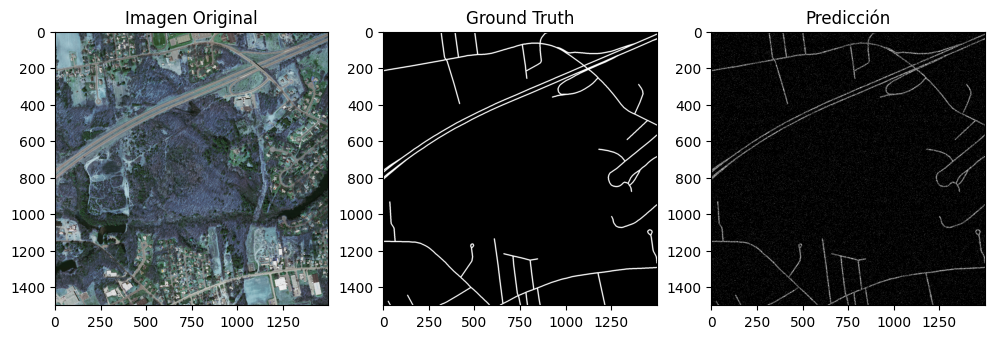

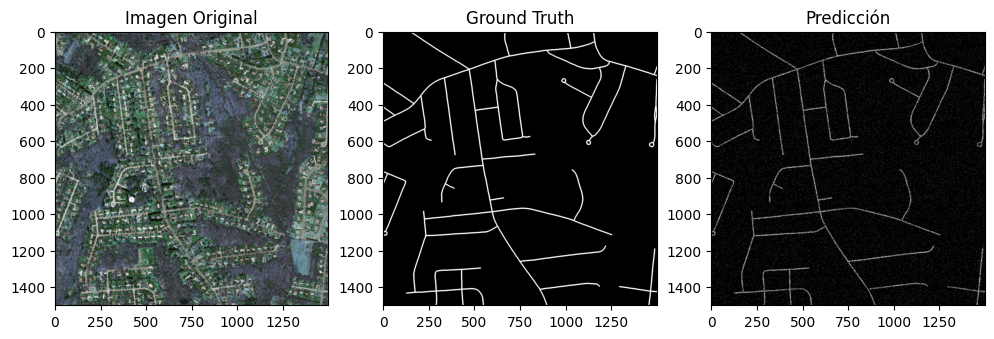

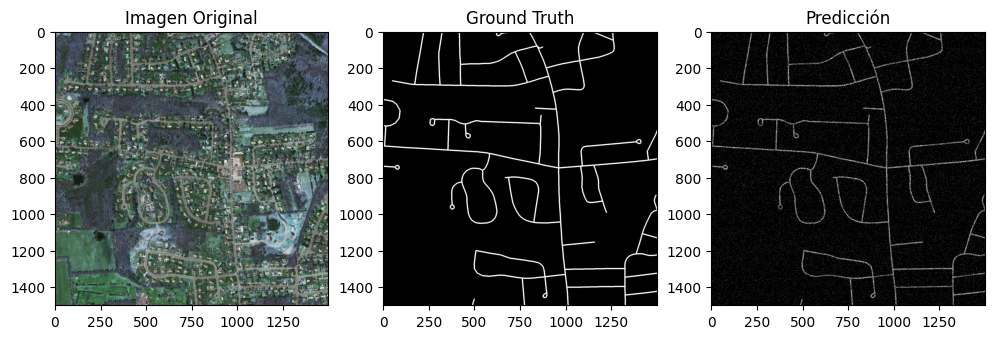

In [9]:
# Aplanar las predicciones y etiquetas reales
y_pred_all = np.hstack(y_pred_all)
y_test_all = np.hstack(y_test_all)

# Visualizar 3 imágenes aleatorias después de evaluar los folds
random_indices = random.sample(range(len(images_test_all)), 3)

for idx in random_indices:
    original_image = images_test_all[idx]
    original_mask = masks_test_all[idx]
    selected_indices = indices_all[idx]
    y_pred_fold = y_pred_all[selected_indices]

    # Reconstruir la máscara de predicción
    mask_pred = reconstruct_original_mask(y_pred_fold, selected_indices, original_image.shape[:2])

    # Visualizar resultados
    visualize_results(original_image, original_mask, mask_pred)